<a href="https://colab.research.google.com/github/RostislavB74/DS_HW5/blob/main/HW5-var7-020224.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Завантаження даних**

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [23]:
import os
import re

# Шлях до папки, де знаходяться папки walking, running, idle, stairs
base_folder = '/content/drive/MyDrive/Colab Notebooks/hw5_1/'

# Створюємо порожній DataFrame для зберігання даних
all_data = pd.DataFrame()

# Ітеруємося по папкам
for activity_folder in os.listdir(base_folder):
    activity_path = os.path.join(base_folder, activity_folder)
    # Перевіряємо, чи це є папкою
    if os.path.isdir(activity_path):
        # Ітеруємося по файлам у папці
        for file_name in os.listdir(activity_path):
            # Перевіряємо, чи файл має розширення .csv
            if file_name.endswith('.csv'):
                file_path = os.path.join(activity_path, file_name)

                activity_data = pd.read_csv(file_path)
                activity_data['activity'] = activity_folder
                num=re.match(f'{activity_folder}-(\d+).csv', file_name)
                activity_data['num']=int(num.group(1))
                all_data = pd.concat([all_data, activity_data], ignore_index=True)

print(type(all_data))

<class 'pandas.core.frame.DataFrame'>


In [24]:
all_data.head()

,accelerometer_X,accelerometer_Y,accelerometer_Z,activity,num
0,0.277727,-0.110133,9.773131,idle,659
1,0.287304,-0.047884,9.758766,idle,659
2,0.292093,-0.067038,9.758766,idle,659
3,0.258574,-0.105345,9.787497,idle,659
4,0.263362,-0.086191,9.768343,idle,659


## **Попередня інформація про дані**

In [25]:
from os import listdir
from os.path import isfile, join
activities= listdir(base_folder)

In [6]:
activities

['idle', 'walking', 'stairs', 'running']

In [26]:
for name in activities:
  path = join(base_folder, name)
  frames= listdir(path)
  print(f'{name} = {len(frames)}')

idle = 1039
walking = 1850
stairs = 165
running = 3408


 **Кількість даних по кожному виду діяльності**

In [27]:
class_counts = all_data['activity'].value_counts()
print(class_counts)

running    102240
walking     55500
idle        31170
stairs       4950
Name: activity, dtype: int64


In [28]:
all_data.head()

,accelerometer_X,accelerometer_Y,accelerometer_Z,activity,num
0,0.277727,-0.110133,9.773131,idle,659
1,0.287304,-0.047884,9.758766,idle,659
2,0.292093,-0.067038,9.758766,idle,659
3,0.258574,-0.105345,9.787497,idle,659
4,0.263362,-0.086191,9.768343,idle,659


In [32]:
all_data.describe()

,accelerometer_X,accelerometer_Y,accelerometer_Z,num
count,193860.000000,193860.000000,193860.000000,193860.000000
mean,1.923550,1.598343,1.804896,1249.626431
std,8.404867,12.474041,7.191590,930.683760
min,-39.188293,-39.188293,-39.188293,1.000000
25%,-2.494758,-8.327033,-2.494758,484.000000
50%,0.248997,-0.009577,0.905008,1022.500000
75%,4.668694,8.671799,7.187394,1822.000000
max,39.188293,39.188293,39.188293,3408.000000


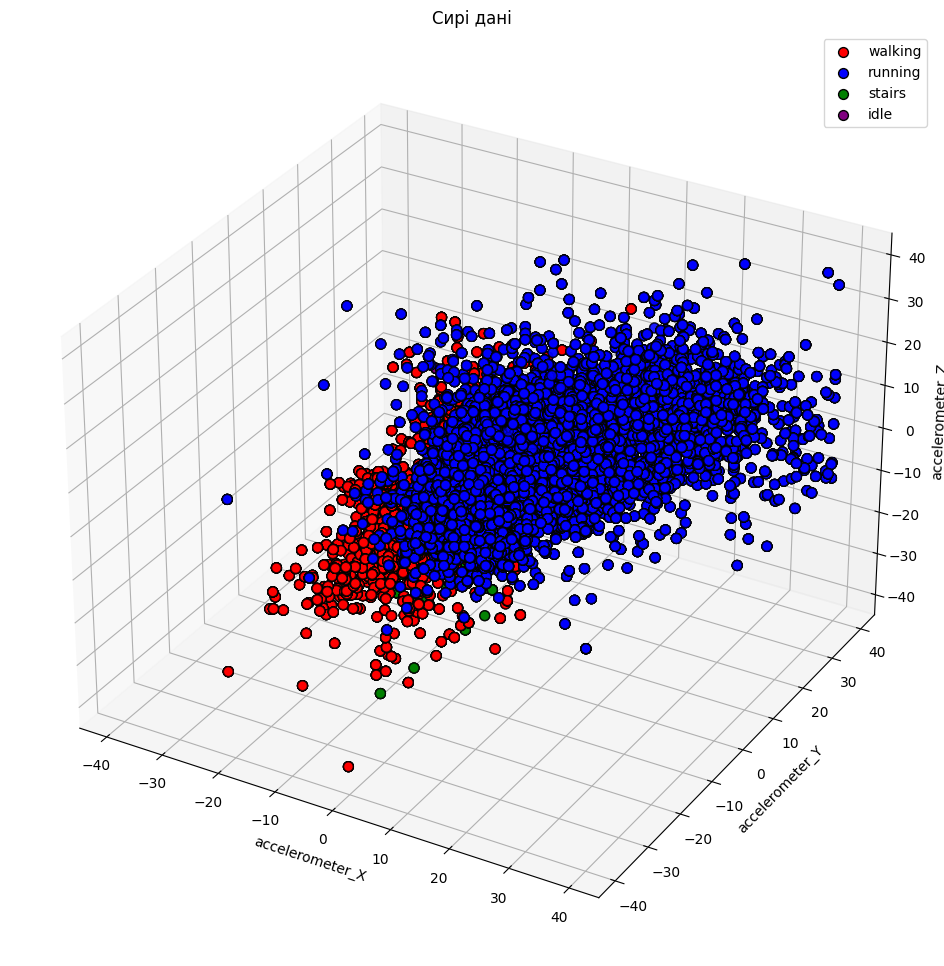

In [31]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

x_values = all_data['accelerometer_X']
y_values = all_data['accelerometer_Y']
z_values = all_data['accelerometer_Z']
activity_labels = all_data['activity']

colors = {'walking': 'red', 'running': 'blue', 'stairs': 'green', 'idle': 'purple'}

for activity, color in colors.items():
    indices = (activity_labels == activity)
    ax.scatter(x_values[indices], y_values[indices], z_values[indices], label=activity, color=color, edgecolors='black', s=50)

ax.set_xlabel('accelerometer_X')
ax.set_ylabel('accelerometer_Y')
ax.set_zlabel('accelerometer_Z')
ax.set_title('Сирі дані')

plt.legend()
plt.show()




## Робота із сирими даними df_raw - це копія all_data

Перші рядки сирого датасету:
   accelerometer_X  accelerometer_Y  accelerometer_Z activity  num
0         0.277727        -0.110133         9.773131     idle  659
1         0.287304        -0.047884         9.758766     idle  659
2         0.292093        -0.067038         9.758766     idle  659
3         0.258574        -0.105345         9.787497     idle  659
4         0.263362        -0.086191         9.768343     idle  659
Статистична інформація:
       accelerometer_X  accelerometer_Y  accelerometer_Z            num
count    193860.000000    193860.000000    193860.000000  193860.000000
mean          1.923550         1.598343         1.804896    1249.626431
std           8.404867        12.474041         7.191590     930.683760
min         -39.188293       -39.188293       -39.188293       1.000000
25%          -2.494758        -8.327033        -2.494758     484.000000
50%           0.248997        -0.009577         0.905008    1022.500000
75%           4.668694         8.671799  

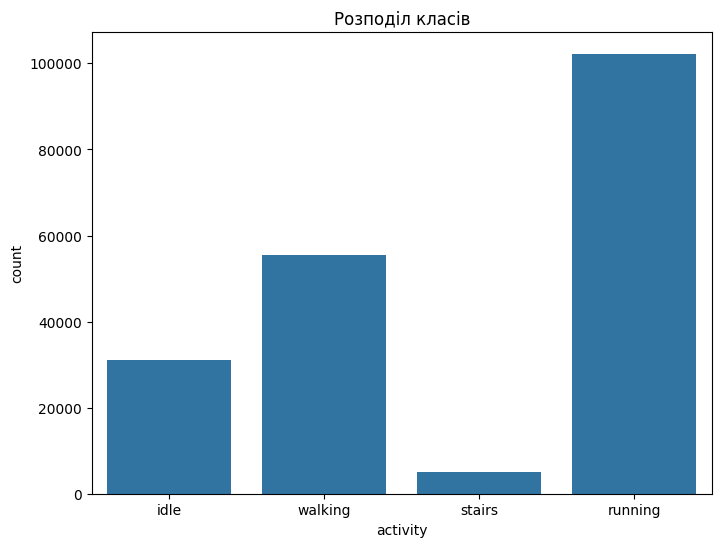

<ipython-input-33-ef75bb84c13c>:27: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_raw.corr(), annot=True, cmap='coolwarm', fmt=".2f")


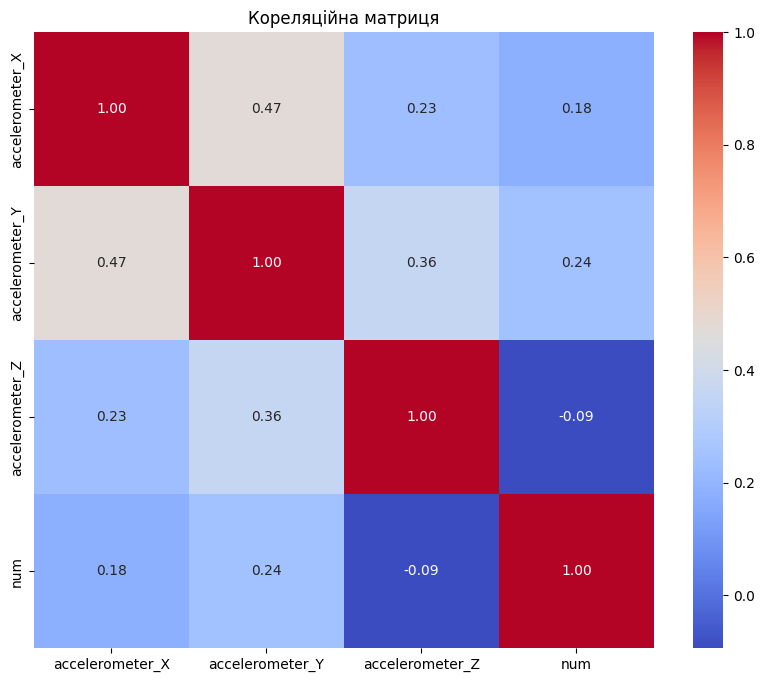

In [33]:
import pandas as pd

# Копіюємо сирі дані
df_raw = all_data.copy()


print("Перші рядки сирого датасету:")
print(df_raw.head())

print("Статистична інформація:")
print(df_raw.describe())

print("Розподіл класів:")
print(df_raw['activity'].value_counts())

# Візуалізація розподілу класів
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(x='activity', data=df_raw)
plt.title('Розподіл класів')
plt.show()

# Візуалізація кореляційної матриці
plt.figure(figsize=(10, 8))
sns.heatmap(df_raw.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Кореляційна матриця')
plt.show()


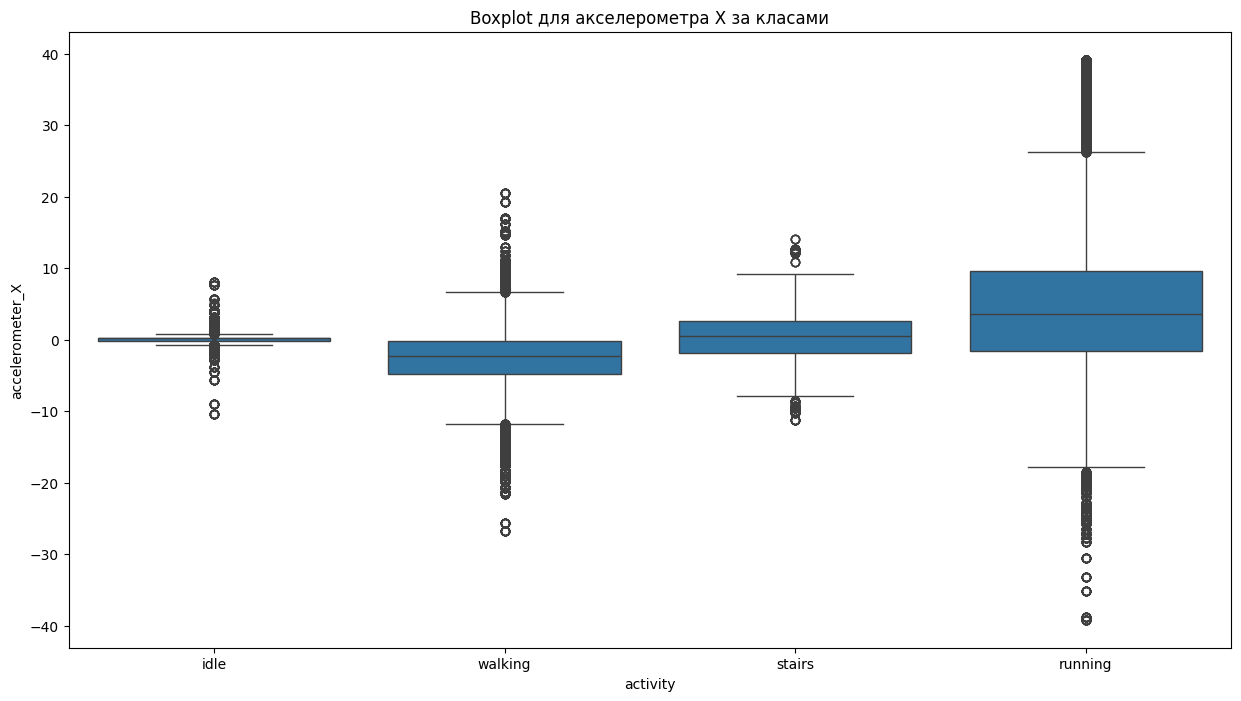

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
sns.boxplot(x='activity', y='accelerometer_X', data=df_raw)
plt.title('Boxplot для акселерометра X за класами')
plt.show()


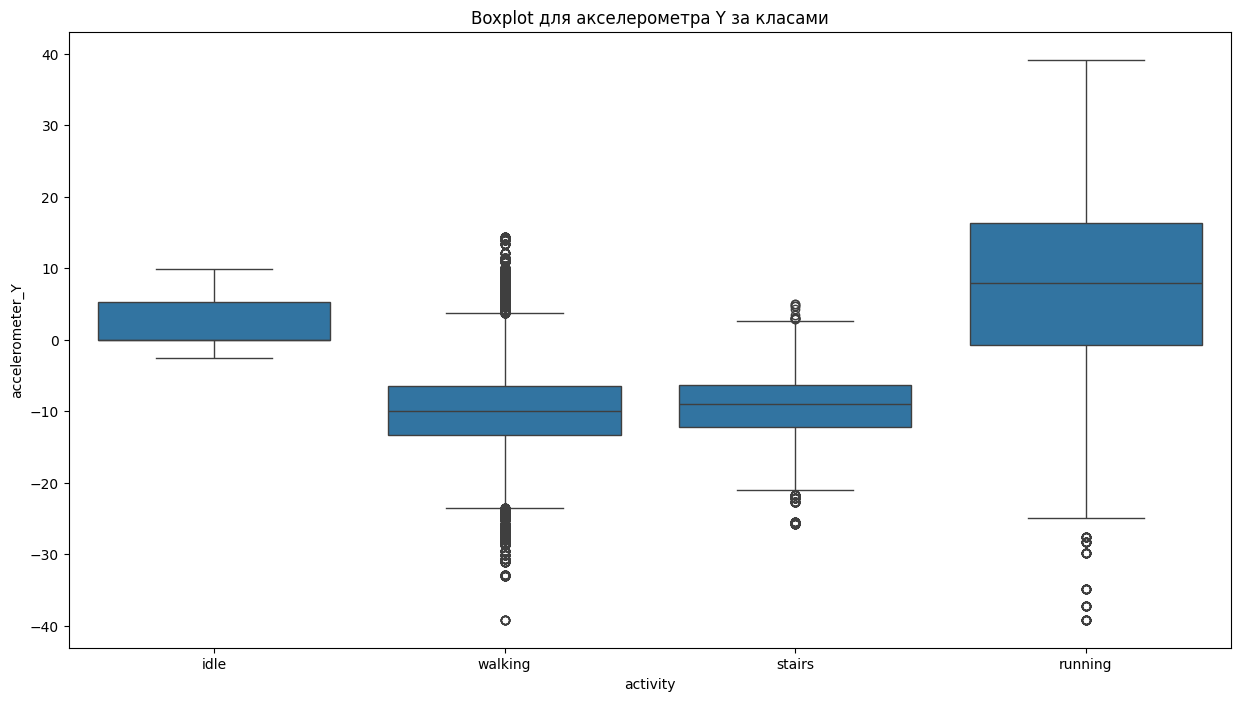

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
sns.boxplot(x='activity', y='accelerometer_Y', data=df_raw)
plt.title('Boxplot для акселерометра Y за класами')
plt.show()

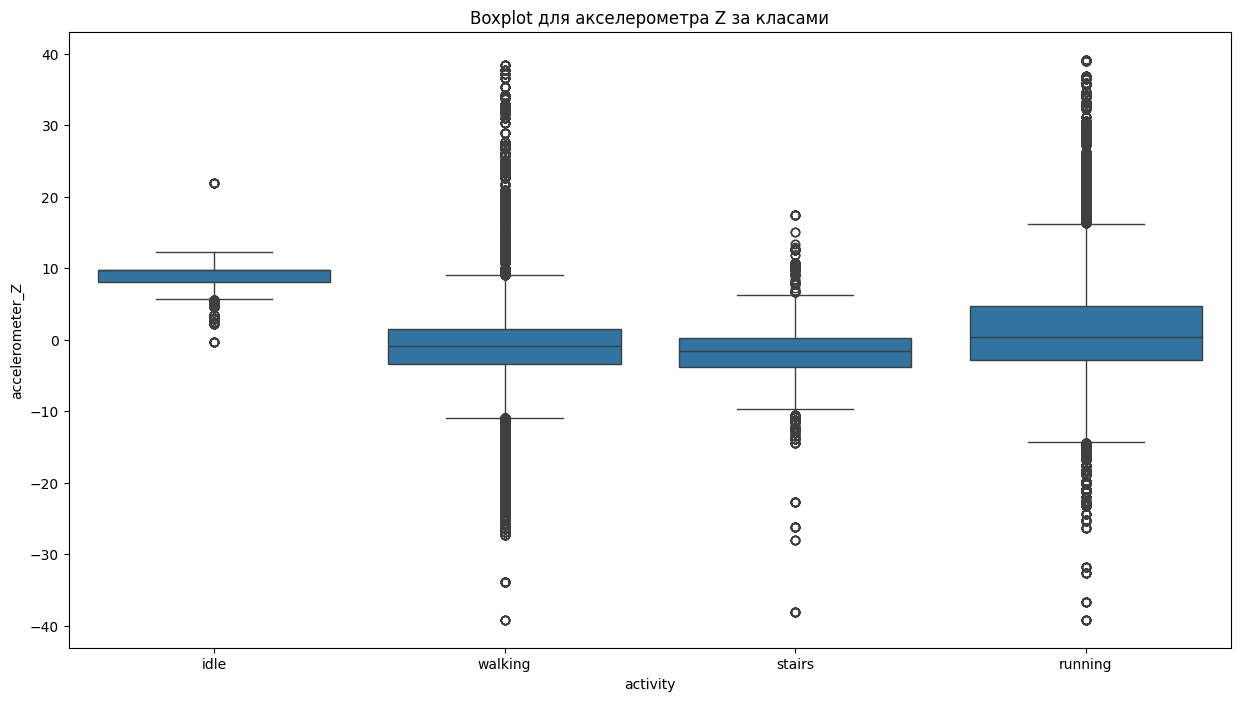

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
sns.boxplot(x='activity', y='accelerometer_Z', data=df_raw)
plt.title('Boxplot для акселерометра Z за класами')
plt.show()

## **Підготовка даних**

## **Очищення даних методами IQR та Z-оцінки**

In [37]:
# Виявлення викидів за допомогою IQR
Q1 = all_data[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']].quantile(0.25)
Q3 = all_data[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']].quantile(0.75)
IQR = Q3 - Q1

# Фільтрація викидів
all_data_no_outliers_iqr = all_data[~((all_data[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']] < (Q1 - 1.5 * IQR)) | (all_data[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']] > (Q3 + 1.5 * IQR))).any(axis=1)]

print("Розмір датасету після обробки викидів за методом IQR:", all_data_no_outliers_iqr.shape)


Розмір датасету після обробки викидів за методом IQR: (173515, 5)


In [41]:
class_counts = all_data_no_outliers_iqr['activity'].value_counts()
print(class_counts)

running    85144
walking    52317
idle       31155
stairs      4899
Name: activity, dtype: int64


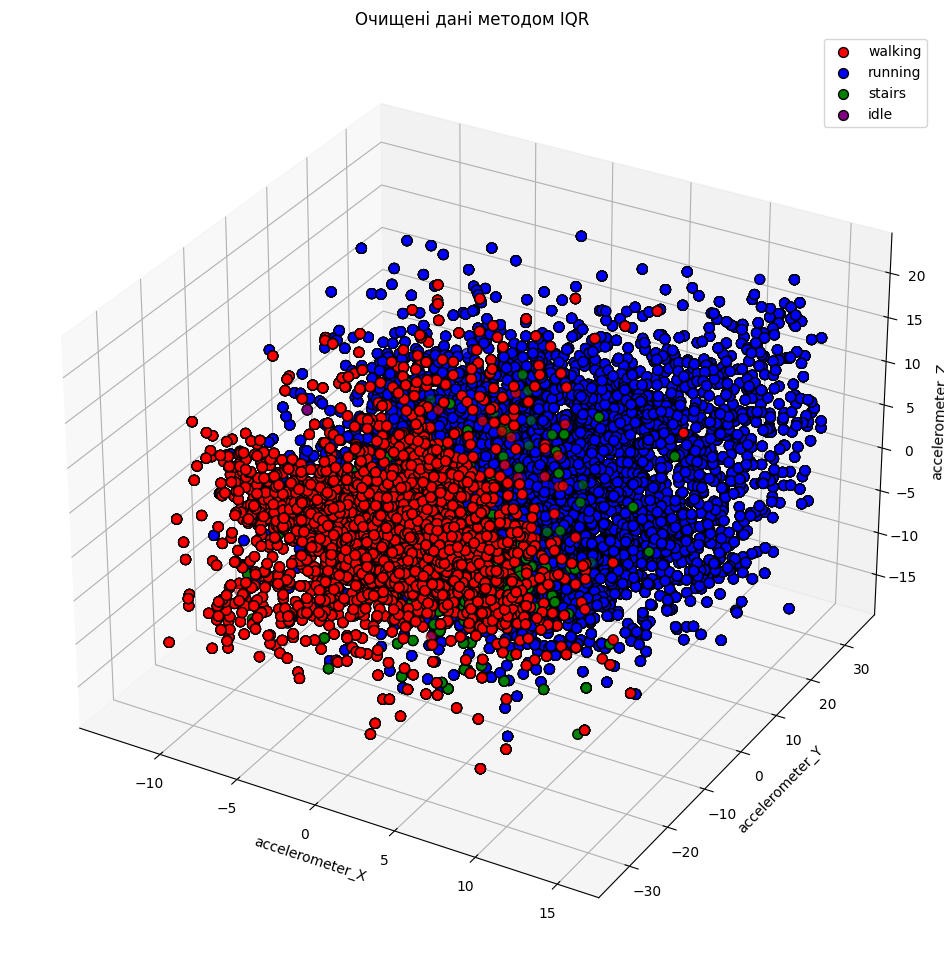

In [39]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

x_values = all_data_no_outliers_iqr['accelerometer_X']
y_values = all_data_no_outliers_iqr['accelerometer_Y']
z_values = all_data_no_outliers_iqr['accelerometer_Z']
activity_labels = all_data_no_outliers_iqr['activity']

colors = {'walking': 'red', 'running': 'blue', 'stairs': 'green', 'idle': 'purple'}

for activity, color in colors.items():
    indices = (activity_labels == activity)
    ax.scatter(x_values[indices], y_values[indices], z_values[indices], label=activity, color=color, edgecolors='black', s=50)

ax.set_xlabel('accelerometer_X')
ax.set_ylabel('accelerometer_Y')
ax.set_zlabel('accelerometer_Z')
ax.set_title('Очищені дані методом IQR')

plt.legend()
plt.show()

In [38]:
from scipy.stats import zscore

# Виявлення викидів за допомогою Z-оцінки
z_scores = np.abs(zscore(all_data[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']]))
all_data_no_outliers_zscore = all_data[(z_scores < 3).all(axis=1)]

print("Розмір датасету після обробки викидів за методом Z-оцінки:", all_data_no_outliers_zscore.shape)


Розмір датасету після обробки викидів за методом Z-оцінки: (187177, 5)


In [42]:
class_counts = all_data_no_outliers_zscore['activity'].value_counts()
print(class_counts)

running    97014
walking    54094
idle       31170
stairs      4899
Name: activity, dtype: int64


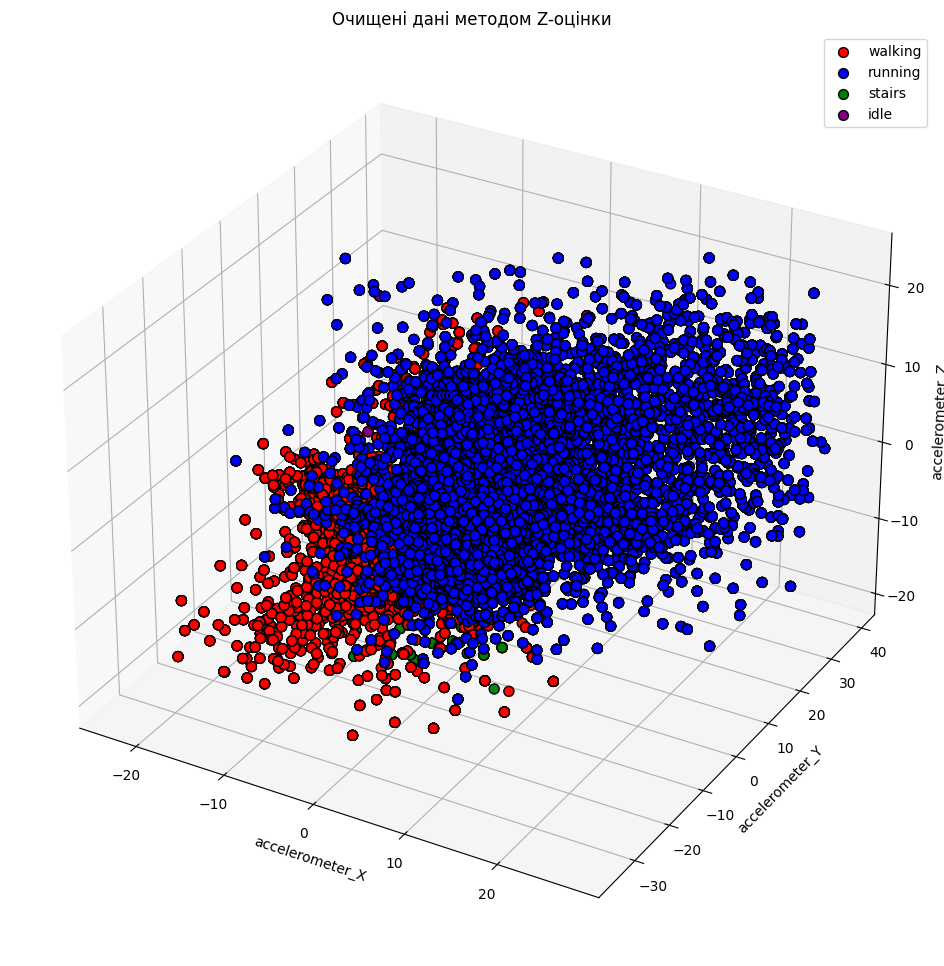

In [40]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

x_values = all_data_no_outliers_zscore['accelerometer_X']
y_values = all_data_no_outliers_zscore['accelerometer_Y']
z_values = all_data_no_outliers_zscore['accelerometer_Z']
activity_labels = all_data_no_outliers_zscore['activity']

colors = {'walking': 'red', 'running': 'blue', 'stairs': 'green', 'idle': 'purple'}

for activity, color in colors.items():
    indices = (activity_labels == activity)
    ax.scatter(x_values[indices], y_values[indices], z_values[indices], label=activity, color=color, edgecolors='black', s=50)

ax.set_xlabel('accelerometer_X')
ax.set_ylabel('accelerometer_Y')
ax.set_zlabel('accelerometer_Z')
ax.set_title('Очищені дані методом Z-оцінки')

plt.legend()
plt.show()

## **Створення та тренування моделей без часових ознак**

In [45]:
# Встановлення ваг класів
class_weights = {'idle': 3408 / 1039, 'walking': 3408 / 1850, 'stairs': 3408 / 165, 'running': 1}

# Підготовка даних
X = all_data_no_outliers_iqr[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']]
y = all_data_no_outliers_iqr['activity']

# Розділення на тренувальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [48]:
# Створення моделі SVM з вагами класів
svm_model = SVC(class_weight=class_weights)
# Тренування моделі
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy SVM: {accuracy}')
print('Classification Report:\n', report)

Accuracy SVM: 0.7843990433103766
Classification Report:
               precision    recall  f1-score   support

        idle       0.95      0.99      0.97      6144
     running       0.97      0.77      0.86     17092
      stairs       0.10      0.66      0.17       939
     walking       0.87      0.70      0.78     10528

    accuracy                           0.78     34703
   macro avg       0.72      0.78      0.69     34703
weighted avg       0.91      0.78      0.83     34703



In [49]:
# Створення моделі RandomForest з вагами класів
rf_model = RandomForestClassifier(class_weight=class_weights)

# Тренування моделі
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred)
report_rf= classification_report(y_test, y_pred)

print(f'Accuracy RFC: {accuracy_rf}')
print('Classification Report:\n', report_rf)

Accuracy RFC: 0.9993084171397285
Classification Report:
               precision    recall  f1-score   support

        idle       1.00      1.00      1.00      6144
     running       1.00      1.00      1.00     17092
      stairs       1.00      0.99      0.99       939
     walking       1.00      1.00      1.00     10528

    accuracy                           1.00     34703
   macro avg       1.00      1.00      1.00     34703
weighted avg       1.00      1.00      1.00     34703



In [50]:
# Встановлення ваг класів
class_weights = {'idle': 3408 / 1039, 'walking': 3408 / 1850, 'stairs': 3408 / 165, 'running': 1}

# Підготовка даних
X_sc = all_data_no_outliers_zscore[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']]
y_sc = all_data_no_outliers_zscore['activity']

# Розділення на тренувальний та тестовий набори
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(X_sc, y_sc, test_size=0.2, random_state=42)


In [51]:
# Створення моделі SVM з вагами класів
svm_model_sc = SVC(class_weight=class_weights)
# Тренування моделі
svm_model_sc.fit(X_train_sc, y_train_sc)

y_pred_sc = svm_model_sc.predict(X_test_sc)

accuracy_sc = accuracy_score(y_test_sc, y_pred_sc)
report_sc = classification_report(y_test_sc, y_pred_sc)

print(f'Accuracy SVM: {accuracy_sc}')
print('Classification Report:\n', report_sc)

Accuracy SVM: 0.7915108451757666
Classification Report:
               precision    recall  f1-score   support

        idle       0.94      0.99      0.96      6213
     running       0.97      0.79      0.87     19445
      stairs       0.10      0.67      0.17       941
     walking       0.88      0.69      0.77     10837

    accuracy                           0.79     37436
   macro avg       0.72      0.79      0.69     37436
weighted avg       0.92      0.79      0.84     37436



In [52]:
# Створення моделі RandomForest з вагами класів
rf_model_sc = RandomForestClassifier(class_weight=class_weights)

# Тренування моделі
rf_model_sc.fit(X_train_sc, y_train_sc)
y_pred_sc = rf_model_sc.predict(X_test_sc)

accuracy_rf_sc = accuracy_score(y_test_sc, y_pred_sc)
report_rf_sc= classification_report(y_test_sc, y_pred_sc)

print(f'Accuracy RFC: {accuracy_rf_sc}')
print('Classification Report:\n', report_rf_sc)

Accuracy RFC: 0.9997328774441714
Classification Report:
               precision    recall  f1-score   support

        idle       1.00      1.00      1.00      6213
     running       1.00      1.00      1.00     19445
      stairs       1.00      0.99      1.00       941
     walking       1.00      1.00      1.00     10837

    accuracy                           1.00     37436
   macro avg       1.00      1.00      1.00     37436
weighted avg       1.00      1.00      1.00     37436



## **Додавання часових ознак до очищених даних IQR**

In [65]:
import pandas as pd
import numpy as np
from scipy.stats import zscore


# Розрахунок метрик
def calculate_metrics(data, component):
    metrics = {}

    metrics[f'accelerometer_{component}_mean'] = data[f'accelerometer_{component}'].mean()
    metrics[f'accelerometer_{component}_max'] = data[f'accelerometer_{component}'].max()
    metrics[f'accelerometer_{component}_interquartile_range'] = np.percentile(data[f'accelerometer_{component}'], 75) - np.percentile(data[f'accelerometer_{component}'], 25)
    metrics[f'accelerometer_{component}_index_of_minimum_value'] = data[f'accelerometer_{component}'].idxmin()
    metrics[f'accelerometer_{component}_mean_of_absolute_deviation'] = np.mean(np.abs(data[f'accelerometer_{component}'] - data[f'accelerometer_{component}'].mean()))
    metrics[f'accelerometer_{component}_median'] = data[f'accelerometer_{component}'].median()
    metrics[f'accelerometer_{component}_standard_deviation'] = data[f'accelerometer_{component}'].std()
    metrics[f'accelerometer_{component}_root_mean_square_error'] = np.sqrt(np.mean(data[f'accelerometer_{component}'] ** 2))


    return metrics

# Розрахунок метрик для кожної компоненти
metrics_X = calculate_metrics(all_data_no_outliers_iqr, 'X')
metrics_Y = calculate_metrics(all_data_no_outliers_iqr, 'Y')
metrics_Z = calculate_metrics(all_data_no_outliers_iqr, 'Z')

# Додавання розрахованих метрик до датафрейму
all_data_no_outliers_iqr = all_data_no_outliers_iqr.assign(**metrics_X, **metrics_Y, **metrics_Z)

# Виведення результатів
print(all_data_no_outliers_iqr[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z', 'accelerometer_X_mean', 'accelerometer_Y_mean', 'accelerometer_Z_mean']])


        accelerometer_X  accelerometer_Y  accelerometer_Z  \
0              0.277727        -0.110133         9.773131   
1              0.287304        -0.047884         9.758766   
2              0.292093        -0.067038         9.758766   
3              0.258574        -0.105345         9.787497   
4              0.263362        -0.086191         9.768343   
...                 ...              ...              ...   
193855        -1.005565       -10.754754        -1.891419   
193856         4.209007        10.381259         1.920150   
193857        -5.176264        33.791763        -7.149086   
193858        -2.561796         3.471593         1.216255   
193859         6.200983         4.074931         0.071826   

        accelerometer_X_mean  accelerometer_Y_mean  accelerometer_Z_mean  
0                   0.497621              -0.05791              1.560444  
1                   0.497621              -0.05791              1.560444  
2                   0.497621              

In [68]:
# Створення списку із словників метрик для кожної компоненти
metrics_list = [metrics_X, metrics_Y, metrics_Z]

# Цикл для виведення всіх метрик
for component, metrics in zip(['X', 'Y', 'Z'], metrics_list):
    print(f"Metrics for accelerometer_{component}:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")
    print("\n")


Metrics for accelerometer_X:
accelerometer_X_mean: 1.3921895309092465
accelerometer_X_max: 27.092787
accelerometer_X_interquartile_range: 6.756437
accelerometer_X_index_of_minimum_value: 96667
accelerometer_X_mean_of_absolute_deviation: 5.0957129282340174
accelerometer_X_median: 0.234632
accelerometer_X_standard_deviation: 7.0918222450677275
accelerometer_X_root_mean_square_error: 7.227161666129631


Metrics for accelerometer_Y:
accelerometer_Y_mean: 1.0529198951794287
accelerometer_Y_max: 38.95845
accelerometer_Y_interquartile_range: 16.342821
accelerometer_Y_index_of_minimum_value: 99140
accelerometer_Y_mean_of_absolute_deviation: 9.60965739679183
accelerometer_Y_median: -0.019154
accelerometer_Y_standard_deviation: 11.850217847192743
accelerometer_Y_root_mean_square_error: 11.89687156741807


Metrics for accelerometer_Z:
accelerometer_Z_mean: 1.6304960697361317
accelerometer_Z_max: 23.367409
accelerometer_Z_interquartile_range: 9.394848
accelerometer_Z_index_of_minimum_value: 37773


## **Додавання часових ознак до очищених даних Z-score**

In [66]:
import pandas as pd
import numpy as np
from scipy.stats import zscore


# Розрахунок метрик
def calculate_metrics(data, component):
    metrics = {}

    metrics[f'accelerometer_{component}_mean'] = data[f'accelerometer_{component}'].mean()
    metrics[f'accelerometer_{component}_max'] = data[f'accelerometer_{component}'].max()
    metrics[f'accelerometer_{component}_interquartile_range'] = np.percentile(data[f'accelerometer_{component}'], 75) - np.percentile(data[f'accelerometer_{component}'], 25)
    metrics[f'accelerometer_{component}_index_of_minimum_value'] = data[f'accelerometer_{component}'].idxmin()
    metrics[f'accelerometer_{component}_mean_of_absolute_deviation'] = np.mean(np.abs(data[f'accelerometer_{component}'] - data[f'accelerometer_{component}'].mean()))
    metrics[f'accelerometer_{component}_median'] = data[f'accelerometer_{component}'].median()
    metrics[f'accelerometer_{component}_standard_deviation'] = data[f'accelerometer_{component}'].std()
    metrics[f'accelerometer_{component}_root_mean_square_error'] = np.sqrt(np.mean(data[f'accelerometer_{component}'] ** 2))


    return metrics


# Розрахунок метрик для кожної компоненти
metrics_X = calculate_metrics(all_data_no_outliers_zscore, 'X')
metrics_Y = calculate_metrics(all_data_no_outliers_zscore, 'Y')
metrics_Z = calculate_metrics(all_data_no_outliers_zscore, 'Z')

# Додавання розрахованих метрик до датафрейму
all_data_no_outliers_zscore = all_data_no_outliers_zscore.assign(**metrics_X, **metrics_Y, **metrics_Z)

# Виведення результатів
print(all_data_no_outliers_zscore[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z', 'accelerometer_X_mean', 'accelerometer_Y_mean', 'accelerometer_Z_mean']])

        accelerometer_X  accelerometer_Y  accelerometer_Z  \
0              0.277727        -0.110133         9.773131   
1              0.287304        -0.047884         9.758766   
2              0.292093        -0.067038         9.758766   
3              0.258574        -0.105345         9.787497   
4              0.263362        -0.086191         9.768343   
...                 ...              ...              ...   
193855        -1.005565       -10.754754        -1.891419   
193856         4.209007        10.381259         1.920150   
193857        -5.176264        33.791763        -7.149086   
193858        -2.561796         3.471593         1.216255   
193859         6.200983         4.074931         0.071826   

        accelerometer_X_mean  accelerometer_Y_mean  accelerometer_Z_mean  
0                    1.39219               1.05292              1.630496  
1                    1.39219               1.05292              1.630496  
2                    1.39219              

## **Начання моделі IQR**

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Розділимо дані на фічі та цільову змінну
X_iqr = all_data_no_outliers_iqr.drop(columns=['activity'])
y_iqr = all_data_no_outliers_iqr['activity']

# Розділимо дані на тренувальний та тестовий набори
X_train_iqr, X_test_iqr, y_train_iqr, y_test_iqr = train_test_split(X_iqr, y_iqr, test_size=0.2, random_state=42)

# Ініціалізуємо модель
model_iqr = RandomForestClassifier(random_state=42)

# Навчання моделі
model_iqr.fit(X_train_iqr, y_train_iqr)

# Прогнозування на тестових даних
y_pred_iqr = model_iqr.predict(X_test_iqr)

# Оцінка результатів
accuracy_iqr = accuracy_score(y_test_iqr, y_pred_iqr)
classification_rep_iqr = classification_report(y_test_iqr, y_pred_iqr)

# Виведення результатів
print(f"Accuracy: {accuracy_iqr}")
print("Classification Report:\n", classification_rep_iqr)


Accuracy: 0.9994813128547965
Classification Report:
               precision    recall  f1-score   support

        idle       1.00      1.00      1.00      6144
     running       1.00      1.00      1.00     17092
      stairs       1.00      0.99      0.99       939
     walking       1.00      1.00      1.00     10528

    accuracy                           1.00     34703
   macro avg       1.00      1.00      1.00     34703
weighted avg       1.00      1.00      1.00     34703



## **Начання моделі Z-score**

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


X_sc_clean = all_data_no_outliers_zscore.drop(columns=['activity'])
y_sc_clean = all_data_no_outliers_zscore['activity']


X_train_sc_clean, X_test_sc_clean, y_train_sc_clean, y_test_sc_clean = train_test_split(X_sc_clean, y_sc_clean, test_size=0.2, random_state=42)


model_sc_clean = RandomForestClassifier(random_state=42)


model_sc_clean.fit(X_train_sc_clean, y_train_sc_clean)


y_pred_sc_clean = model_sc_clean.predict(X_test_sc_clean)


accuracy_sc_clean = accuracy_score(y_test_sc_clean, y_pred_sc_clean)
classification_rep_sc_clean = classification_report(y_test_sc_clean, y_pred_sc_clean)

# Виведення результатів
print(f"Accuracy: {accuracy_sc_clean}")
print("Classification Report:\n", classification_rep_sc_clean)

Accuracy: 0.9997061651885886
Classification Report:
               precision    recall  f1-score   support

        idle       1.00      1.00      1.00      6213
     running       1.00      1.00      1.00     19445
      stairs       1.00      0.99      1.00       941
     walking       1.00      1.00      1.00     10837

    accuracy                           1.00     37436
   macro avg       1.00      1.00      1.00     37436
weighted avg       1.00      1.00      1.00     37436

